# A3: NeuralNetwork Class

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1">Requirements</a></span></li><li><span><a href="#Code-for-NeuralNetwork-Class-Saved-in-File-neuralnetworkA3.py" data-toc-modified-id="Code-for-NeuralNetwork-Class-Saved-in-File-neuralnetworkA3.py-2">Code for <code>NeuralNetwork</code> Class Saved in File <code>neuralnetworkA3.py</code></a></span></li><li><span><a href="#Example-Results" data-toc-modified-id="Example-Results-3">Example Results</a></span></li><li><span><a href="#Application-to-Seoul-Bike-Sharing-Demand-Data" data-toc-modified-id="Application-to-Seoul-Bike-Sharing-Demand-Data-4">Application to Seoul Bike Sharing Demand Data</a></span></li></ul></div>

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, starting with the code included in the next code cell.  Your implementation must meet the requirements described in the doc-strings.

Run the code in [05 Optimizers](https://www.cs.colostate.edu/~anderson/cs545/notebooks/05%20Optimizers.ipynb) to create the file `optimizers.py` for use in this assignment.

Then apply your `NeuralNetwork` class to the problem of predicting the value of houses in Boston as described below.

## Code for `NeuralNetwork` Class Saved in File `neuralnetworkA3.py`

In [1]:
%%writefile neuralnetworkA3.py

import numpy as np
import optimizers as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression.

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hidden_units_by_layers : list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs : int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
   performance_trace : list of floats
        Mean square error (unstandardized) after each epoch
    n_epochs : int
        Number of epochs trained so far
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples
        
        
    Methods
    -------
    make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(X, T, n_epochs, method='sgd', learning_rate=None, verbose=True)
        Trains the network using input and target samples by rows in X and T

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, n_inputs, n_hidden_units_by_layers, n_outputs):
        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hidden_units_by_layers : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        # Assign attribute values. 
        self.n_inputs = n_inputs
        self.n_hidden_units_by_layers = n_hidden_units_by_layers
        self.n_outputs = n_outputs
        self.n_epochs = 0
        # Set performance_trace to [].
        self.performance_trace = []
        # Set self.X_means to None to indicate
        # that standardization parameters have not been calculated.
        # ....
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None
        
        # Build list of shapes for weight matrices in each layer
        # ...
        shapes = []
        nh = 0
        ni = self.n_inputs
        for nh in self.n_hidden_units_by_layers:
            shapes.append((1 + ni, nh))
            ni = nh
        #Output Layer
        ni = nh if nh > 0 else ni
        nu = self.n_outputs
        shapes.append((1 + ni, nu))
        # Call make_weights_and_views to create all_weights and Ws
        
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Call make_weights_and_views to create all_gradients and Grads
        
        self.all_gradients, self.Grads = self.make_weights_and_views(shapes)


    def make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer.
            Number of rows is number of inputs to layer (including constant 1).
            Number of columns is number of units, or outputs, in layer.

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """

        # Create one-dimensional numpy array of all weights with random initial values

        #  ...
        W_shape = np.array(shapes)
        shape_sum = np.sum(W_shape[:, 0] * W_shape[:, 1])
        weights = np.random.uniform(-0.1, 0.1, shape_sum)

        # Build weight matrices as list of views (pairs of number of rows and number 
        # of columns) by reshaping corresponding elements from vector of all weights 
        # into correct shape for each layer. 
        
        # ...
        temp = 0
        Ws = []
        for i in W_shape:
            init = temp + i[0] * i[1]
            Ws.append(weights[temp:init].reshape(i[0], i[1]))
            temp = init
        # Divide values of each weight matrix by square root of number of its inputs.

        for W in Ws:
            sqrt_input = np.sqrt(W.shape[0])
            for val in W:
                val = val/sqrt_input
        
        # Set output layer weights to zero.
        
        Ws[-1][:,:]=0
        
        return weights, Ws
        
    def __repr__(self):
        return 'NeuralNetwork({}, {}, {})'.format(self.n_inputs, self.n_hiddens_each_layer, self.n_outputs)

    def __str__(self):
        s = self.__repr__()
        if self.total_epochs > 0:
            s += '\n Trained for {} epochs.'.format(self.n_epochs)
            s += '\n Final standardized training error {:.4g}.'.format(self.performance_trace[-1])
        return s
 
    def train(self, X, T, n_epochs, method='sgd', learning_rate=None, verbose=True):
        """Updates the weights.

        Parameters
        ----------
        X : two-dimensional numpy array 
            number of samples  by  number of input components
        T : two-dimensional numpy array
            number of samples  by  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        verbose: boolean
            If True, progress is shown with print statements
        """
        n_samples, n_inputs = X.shape
        _, n_outputs = T.shape

        # Calculate and assign standardization parameters
        self.X_means = np.mean(X, axis=0)
        self.X_stds = np.std(X, axis=0)
        self.T_means = np.mean(T, axis=0)
        self.T_stds = np.std(T, axis=0)

        # Standardize X and T.  Assign back to X and T.
        
        X = (X - self.X_means) / self.X_stds
        T = (T - self.T_means) / self.T_stds

        # Instantiate Optimizers object by giving it vector of all weights
        
        optimizer = opt.Optimizers(self.all_weights)

        # Define function to convert mean-square error to root-mean-square error,
        # Here we use a lambda function just to illustrate its use.  
        # We could have also defined this function with
        # def error_convert_f(err):
        #     return np.sqrt(err)

        error_convert_f = lambda err: np.sqrt(err)
        
        # Call the requested optimizer method to train the weights.

        if method == 'sgd':

            performance_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                              fargs=[X, T], n_epochs=n_epochs,
                                              learning_rate=learning_rate,
                                              error_convert_f=error_convert_f, 
                                              error_convert_name='RMSE',
                                              verbose=verbose)

        elif method == 'adam':

            performance_trace = optimizer.adam(self.error_f, self.gradient_f,
                                               fargs=[X, T], n_epochs=n_epochs,
                                               learning_rate=learning_rate,
                                               error_convert_f=error_convert_f, 
                                               error_convert_name='RMSE',
                                               verbose=verbose)

        elif method == 'scg':

            performance_trace = optimizer.scg(self.error_f, self.gradient_f,
                                              fargs=[X, T], n_epochs=n_epochs,
                                              error_convert_f=error_convert_f, 
                                              error_convert_name='RMSE',
                                              verbose=verbose)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.n_epochs += len(performance_trace)
        self.performance_trace += performance_trace

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def _add_ones(self, X):
        return np.insert(X, 0, 1, 1)
    
    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X.
        
        Parameters
        ----------
        X : input samples, standardized.

        Returns
        -------
        Standardized outputs of all layers as list, include X as first element.
        """
        Z_previous_layer = X
        self.Zs = [X]
        
        # Append output of each layer to list in self.Zs, then return it.
        
        for W_layer in self.Ws[:-1]:
            Z_previous_layer = np.tanh(self._add_ones(Z_previous_layer) @ W_layer)
            self.Zs.append(Z_previous_layer)  # save for gradient calculations
        # Output Layer
        Y = self._add_ones(Z_previous_layer) @ self.Ws[-1]
        self.Zs.append(Y)
        return Y

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net given input X and its mean squared error.
        Function to be minimized by optimizer.

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  by  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  by  number of output components

        Returns
        -------
        Standardized mean square error as scalar float that is the mean
        square error over all samples and all network outputs.
        """
        # Call _forward, calculate mean square error and return it.
        Y = self._forward(X)
        #error = (T - Y) * self.T_stds 
        error = (T - Y)
        result = np.mean(error ** 2)
        return result

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called
        so input and all layer outputs stored in self.Zs

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  x  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """

        # Assumes forward_pass just called with layer outputs saved in self.Zs.
        
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        n_layers = len(self.n_hidden_units_by_layers) + 1

        # delta is delta matrix to be back propagated.
        # Dividing by n_samples and n_outputs here replaces the scaling of
        # the learning rate.
        
        delta = -(T - self.Zs[-1]) / (n_samples * n_outputs)

        # Step backwards through the layers to back-propagate the error (delta)
        
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.Grads[layeri][:] = self._add_ones(self.Zs[layeri]).T @ delta
           # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Zs[layeri]**2)

        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples as rows in X.
        X assumed to not be standardized.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  by  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  by  number of outputs
        """

        # Standardize X
        
        X_st = (X - self.X_means) / self.X_stds
        
        # Unstandardize output Y before returning it
        Y = self._forward(X_st)
        Y = Y * self.T_stds + self.T_means
        return Y

    def get_performance_trace(self):
        """Returns list of unstandardized root-mean square error for each epoch"""
        return self.performance_trace

Overwriting neuralnetworkA3.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetworkA3 as nn  # Your file produced from the above code cell.


In [3]:
X = np.arange(0, 2, 0.5).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
# Set all weights here to allow comparison of your calculations
# Must use [:] to overwrite values in all_weights.
# Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001

nnet.train(X, T, n_epochs=1, method='sgd', learning_rate=0.1)

nnet.Ws

sgd: Epoch 1 RMSE=1.00005


[array([[-1.51603124e-07,  9.99801782e-04],
        [ 2.00719909e-03,  3.00940664e-03]]),
 array([[0.00398889, 0.00498788],
        [0.00600106, 0.00700115],
        [0.00800157, 0.00900172]]),
 array([[0.00898958],
        [0.01099768],
        [0.01199691]])]

In [4]:
nnet.Zs

[array([[-1.34164079],
        [-0.4472136 ],
        [ 0.4472136 ],
        [ 1.34164079]]),
 array([[-0.00268328, -0.00302491],
        [-0.00089443, -0.00034164],
        [ 0.00089443,  0.00234164],
        [ 0.00268328,  0.00502488]]),
 array([[0.00395968, 0.00495395],
        [0.00399188, 0.00499062],
        [0.00402408, 0.00502729],
        [0.00405628, 0.00506396]]),
 array([[0.010103  ],
        [0.0101038 ],
        [0.01010459],
        [0.01010539]])]

In [5]:
nnet.Grads

[array([[ 1.51603124e-06,  1.98217653e-06],
        [-7.19909102e-05, -9.40663907e-05]]),
 array([[ 1.11145896e-04,  1.21249680e-04],
        [-1.05587719e-05, -1.15185542e-05],
        [-1.57268813e-05, -1.71564392e-05]]),
 array([[1.01041953e-02],
        [2.32194989e-05],
        [3.09340617e-05]])]

In [6]:
Y = nnet.use(X)
Y

array([[-0.06308723],
       [-0.06308687],
       [-0.06308651],
       [-0.06308615]])


method is sgd and rho is 0.05

sgd: Epoch 1000 RMSE=1.00000
sgd: Epoch 2000 RMSE=1.00000
sgd: Epoch 3000 RMSE=0.99539
sgd: Epoch 4000 RMSE=0.97261
sgd: Epoch 5000 RMSE=0.68183
sgd: Epoch 6000 RMSE=0.55867
sgd: Epoch 7000 RMSE=0.54350
sgd: Epoch 8000 RMSE=0.43648
sgd: Epoch 9000 RMSE=0.40725
sgd: Epoch 10000 RMSE=0.39496

method is adam and rho is 0.02

Adam: Epoch 1000 RMSE=0.83076
Adam: Epoch 2000 RMSE=0.64693
Adam: Epoch 3000 RMSE=0.64615
Adam: Epoch 4000 RMSE=0.64569
Adam: Epoch 5000 RMSE=0.64550
Adam: Epoch 6000 RMSE=0.64539
Adam: Epoch 7000 RMSE=0.64538
Adam: Epoch 8000 RMSE=0.64527
Adam: Epoch 9000 RMSE=0.64523
Adam: Epoch 10000 RMSE=0.64520

method is scg and rho is None

SCG: Iteration 1000 RMSE=0.64484
SCG: Iteration 2000 RMSE=0.46839
SCG: Iteration 3000 RMSE=0.45866
SCG: Iteration 4000 RMSE=0.45423
SCG: Iteration 5000 RMSE=0.30724
SCG: Iteration 6000 RMSE=0.28793
SCG: Iteration 7000 RMSE=0.28371
SCG: Iteration 8000 RMSE=0.28102
SCG: Iteration 9000 RMSE=0.27964
SCG: Iteration

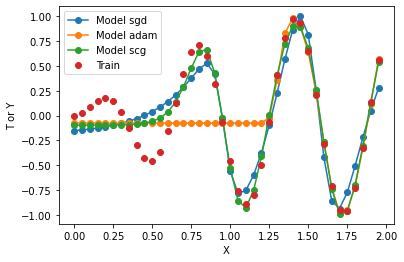

In [7]:
X = np.arange(0, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

n_epochs = 10000
method_rhos = [('sgd', 0.05),
               ('adam', 0.02),
               ('scg', None)]
errors = []
for method, rho in method_rhos:
    
    print('\n=========================================')
    print(f'method is {method} and rho is {rho}')
    print('=========================================\n')

    nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
    # Set all weights here to allow comparison of your calculations
    # Must use [:] to overwrite values in all_weights.
    # Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
    nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001
    
    nnet.train(X, T, n_epochs, method=method, learning_rate=rho)
    Y = nnet.use(X)
    errors.append(nnet.get_performance_trace())
    plt.plot(X, Y, 'o-', label='Model ' + method)

plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

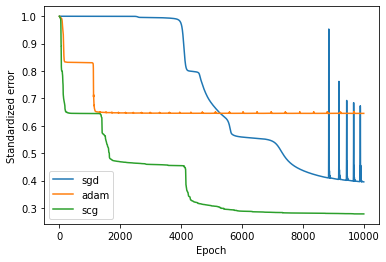

In [8]:
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

## Application to Seoul Bike Sharing Demand Data

Download data from [bike-sharing.csv](https://www.cs.colostate.edu/~anderson/cs545/notebooks/bike-sharing.csv).  This is data modified very slightly from [UC Irvine ML Repo](https://archive-beta.ics.uci.edu/ml/datasets/seoul+bike+sharing+demand#Abstract). Read it into python using the `pandas.read_csv` function.  Assign `X` and `T` as shown.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd  # for display and clear_output
import time

In [10]:
import pandas

data = pandas.read_csv('SeoulBikeData.csv')
T = data['Rented Bike Count'].to_numpy().reshape(-1, 1)
X = data[['Hour', 'Temperature(C)', 'Humidity(%)',
          'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
          'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']].to_numpy()
X.shape, T.shape

((8760, 9), (8760, 1))

Before training your neural networks, partition the data into training and testing partitions, as shown here.

In [11]:
def partition(X, T, train_fraction):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)

    n_train = round(n_samples * train_fraction)

    Xtrain = X[rows[:n_train], :]
    Ttrain = T[rows[:n_train], :]
    Xtest = X[rows[n_train:], :]
    Ttest = T[rows[n_train:], :]

    return Xtrain, Ttrain, Xtest, Ttest

def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

In [12]:
# Assuming you have assigned `X` and `T` correctly.

Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((7008, 9), (7008, 1), (1752, 9), (1752, 1))

In [13]:
n_epochs = 100
method_rhos = [('sgd', 0.05),
               ('adam', 0.02),
               ('scg', None)]
errors = []
for method, rho in method_rhos:
    
    print('\n=========================================')
    print(f'method is {method} and rho is {rho}')
    print('=========================================\n')

    nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
    # Set all weights here to allow comparison of your calculations
    # Must use [:] to overwrite values in all_weights.
    # Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
    nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001
    
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho)
    Y = nnet.use(Xtrain)
    errors.append(nnet.get_performance_trace() * nnet.T_stds)


method is sgd and rho is 0.05

sgd: Epoch 10 RMSE=0.99999
sgd: Epoch 20 RMSE=0.99997
sgd: Epoch 30 RMSE=0.99994
sgd: Epoch 40 RMSE=0.99988
sgd: Epoch 50 RMSE=0.99978
sgd: Epoch 60 RMSE=0.99956
sgd: Epoch 70 RMSE=0.99899
sgd: Epoch 80 RMSE=0.99716
sgd: Epoch 90 RMSE=0.98913
sgd: Epoch 100 RMSE=0.93742

method is adam and rho is 0.02

Adam: Epoch 10 RMSE=0.96850
Adam: Epoch 20 RMSE=0.81084
Adam: Epoch 30 RMSE=0.72163
Adam: Epoch 40 RMSE=0.70916
Adam: Epoch 50 RMSE=0.70479
Adam: Epoch 60 RMSE=0.69860
Adam: Epoch 70 RMSE=0.69576
Adam: Epoch 80 RMSE=0.69390
Adam: Epoch 90 RMSE=0.68978
Adam: Epoch 100 RMSE=0.67562

method is scg and rho is None

SCG: Iteration 10 RMSE=0.73312
SCG: Iteration 20 RMSE=0.69564
SCG: Iteration 30 RMSE=0.67172
SCG: Iteration 40 RMSE=0.65201
SCG: Iteration 50 RMSE=0.63367
SCG: Iteration 60 RMSE=0.62424
SCG: Iteration 70 RMSE=0.62017
SCG: Iteration 80 RMSE=0.61344
SCG: Iteration 90 RMSE=0.61123
SCG: Iteration 100 RMSE=0.61080


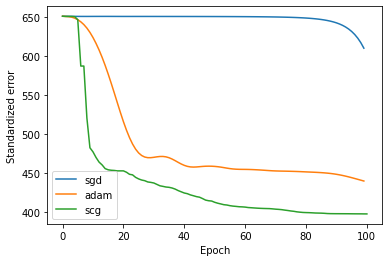

In [14]:
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Write and run code using your `NeuralNetwork` class to model the Seoul bike sharing data. Experiment with all three optimization methods and a variety of neural network structures (numbers of hidden layer and units), learning rates, and numbers of epochs. Show results for at least three different network structures, learning rates, and numbers of epochs for each method.  Show your results in a pandas DataFrame with columns `('Method', 'Structure', 'Epochs', 'Learning Rate', 'Train RMSE', 'Test RMSE')`, where `Train RMSE` and `Test RMSE` are unstandardized errors. 

Use the `pandas` functions `sort_values` and `head` to show the top 20 best results, with "best" being the lowest `Test RMSE`.

Try to find good values for the RMSE on testing data.  Discuss your results, including how good you think the RMSE values are by considering the range of bike sharing counts given in the data. 

In [15]:
def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

n_inputs = Xtrain.shape[1]
n_outputs = Ttrain.shape[1]

df = pandas.DataFrame(columns=('Method','Structure', 'Epochs', 'Learning Rate', 
                                           'Train RMSE', 'Test RMSE'))
methods = ['sgd','adam','scg']
results = []
for method in methods:
    for hiddens in [[50,20,10,3], [10,5,3], []]:
        for epochs in [20, 100, 1000]:
            for lr in [0.1,0.01,0.001]:
                nnet = nn.NeuralNetwork(n_inputs, hiddens, n_outputs)
                nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001
                nnet.train(Xtrain, Ttrain, epochs, method=method, learning_rate=lr)
                rmse_train = rmse(nnet.use(Xtrain), Ttrain)
                rmse_test = rmse(nnet.use(Xtest), Ttest)
                results.append([method, hiddens, epochs, lr, rmse_train, rmse_test])
            
                df = pandas.DataFrame(results, 
                                  columns=('Method','Structure', 'Epochs', 'Learning Rate', 
                                           'Train RMSE', 'Test RMSE'))
                ipd.clear_output(wait=True)

                print(df.sort_values(by='Test RMSE', ascending=True).head(20))

   Method        Structure  Epochs  Learning Rate  Train RMSE   Test RMSE
71    scg       [10, 5, 3]    1000          0.001  315.035650  303.467357
70    scg       [10, 5, 3]    1000          0.010  315.035650  303.467357
69    scg       [10, 5, 3]    1000          0.100  315.035650  303.467357
42   adam       [10, 5, 3]    1000          0.100  314.931806  312.747869
43   adam       [10, 5, 3]    1000          0.010  330.765938  320.108901
15    sgd       [10, 5, 3]    1000          0.100  347.428955  333.031385
68    scg       [10, 5, 3]     100          0.001  380.661125  358.723754
67    scg       [10, 5, 3]     100          0.010  380.661125  358.723754
66    scg       [10, 5, 3]     100          0.100  380.661125  358.723754
39   adam       [10, 5, 3]     100          0.100  368.281866  360.520657
44   adam       [10, 5, 3]    1000          0.001  437.580813  409.724368
16    sgd       [10, 5, 3]    1000          0.010  450.993305  422.625532
63    scg       [10, 5, 3]      20    

In [16]:
rmse_col = df['Test RMSE'].to_numpy().reshape(-1, 1)

In [17]:
min_rmse = rmse_col.min()
min_rmse

303.4673571271383

In [18]:
min_rmse/(Ttrain.max()-Ttrain.min())

0.08533952675116376

In [19]:
def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

n_inputs = Xtrain.shape[1]
n_outputs = Ttrain.shape[1]

df = pandas.DataFrame(columns=('Method','Structure', 'Epochs', 'Learning Rate', 
                                           'Train RMSE', 'Test RMSE'))
methods = ['sgd','adam','scg']
results = []
for method in methods:
    for hiddens in [ [] ]:
        for epochs in [10, 100, 500, 1000, 5000]:
            for lr in [0.001, 0.01, 0.1, 0.2]:
                nnet = nn.NeuralNetwork(n_inputs, hiddens, n_outputs)
                nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001
                nnet.train(Xtrain, Ttrain, epochs, method=method, learning_rate=lr)
                rmse_train = rmse(nnet.use(Xtrain), Ttrain)
                rmse_test = rmse(nnet.use(Xtest), Ttest)
                results.append([method, hiddens, epochs, lr, rmse_train, rmse_test])
            
                df = pandas.DataFrame(results, 
                                  columns=('Method','Structure', 'Epochs', 'Learning Rate', 
                                           'Train RMSE', 'Test RMSE'))
                ipd.clear_output(wait=True)

                print(df.sort_values(by='Test RMSE', ascending=True).head(20))

   Method Structure  Epochs  Learning Rate  Train RMSE   Test RMSE
27   adam        []     100          0.200  474.354645  448.932916
59    scg        []    5000          0.200  474.322245  448.933695
58    scg        []    5000          0.100  474.322245  448.933695
44    scg        []     100          0.001  474.322245  448.933695
45    scg        []     100          0.010  474.322245  448.933695
46    scg        []     100          0.100  474.322245  448.933695
47    scg        []     100          0.200  474.322245  448.933695
48    scg        []     500          0.001  474.322245  448.933695
50    scg        []     500          0.100  474.322245  448.933695
51    scg        []     500          0.200  474.322245  448.933695
49    scg        []     500          0.010  474.322245  448.933695
55    scg        []    1000          0.200  474.322245  448.933695
54    scg        []    1000          0.100  474.322245  448.933695
53    scg        []    1000          0.010  474.322245  448.93

The best Test RMSE achieved is 303.4. his is only about 8% of the target range. This was for the largest network tried 'sgd', hidden layers ([10, 5, 3]), 1,000 epochs, and learning rate of 0.001.

We discovered that decreasing the learning rate while increasing the number of epochs and hidden layers led to a decrease in the RMSE when the neural network was optimized using SGD. Additionally, the RMSE for testing and training was similar.

The RMSE for the training dataset was found to be reduced by decreasing the learning rate while increasing the number of epochs and hidden layers; however, the RMSE for the testing dataset initially decreased and subsequently increased. Additionally, the RMSE for training and testing were initially comparable when the number of hidden layers was low, but as we increased the number of hidden layers and units in each layer, as well as decreased the learning rate and increased the number of epochs, the difference between the RMSE for training and testing grew.

The RMSE for the training dataset was found to be reduced by decreasing the learning rate while increasing the number of epochs, hidden layers, and units in each hidden layer; however, the RMSE for the testing dataset increased. As we increased the number of hidden layers and units in each layer, as well as decreased the learning rate and increased the number of epochs, the RMSE for training and testing became increasingly different from each other. This difference was first noticeable when the number of hidden layers was low.

Linear networks (with no hidden units) did not get lower than about 448.9 Test RMSE, for adam optimiser, the highest number of epochs tested (100) and highest learning rate tested (0.2).

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session. As always, a different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A3.ipynb' with 'Lastname' being your last name, and then save this notebook. Check in your notebook in Canvas.

In [20]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Podder-A3.ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook Podder-A3.ipynb to script


Removing all statements that are not function or class defs or import statements.

Testing

    import neuralnetworkA3 as nn

    n_inputs = 3
    n_hiddens = [5, 10, 20]
    n_outputs = 2
    n_samples = 10

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    
    nnet = nn.NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.all_weights[:] = 0.1  # set all weights to 0.1
    nnet.X_means = np.mean(X, axis=0)
    nnet.X_stds = np.std(X, axis=0)
    nnet.T_means = np.zeros((n_samples, n_outputs))
    nnet.T_stds = np.ones((n_samples, n_outputs))
    
    Y = nnet.use(X)


--- 40/40 points. Returned correct value.

Testing
    n_inputs = 3
    n_hiddens = [6, 3]
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    T = np.log(X + 0.1)
    n_outputs = T.shape[1]
    
    def rmse(A, B):
        return np.sqrt(np.mean((A - B)**2))

    results = []
    for rep in range(20):
        nnet = nn.NeuralNetwork(n_inputs, n

<Figure size 432x288 with 0 Axes>

# Extra Credit

Using a network that gives you pretty good test RMSE results, try to figure out which input features are most significant in predicting the bike-share count.  Remember, that our neural networks is trained with standardized inputs, so you can compare the magnitudes of weights in the first layer to help you determine which inputs are most significant. 

To visualize the weights, try displaying the weights in the first layer as an image, with `plt.imshow` with `plt.colorbar()`. Discuss which weights have the largest magnitudes and discuss any patterns in see in the weights in each hidden unit of the first layer.

In [21]:
import pandas as pd
data = pd.read_csv('boston.csv',usecols=range(14), na_values=None)

In [22]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [23]:
X_data = pd.read_csv('boston.csv', usecols=range(13))
T_data = data['MEDV']
X = np.asarray(X_data)
T = np.asarray(T_data).reshape(-1,1)
X.shape,T.shape

((506, 13), (506, 1))

In [24]:

Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((405, 13), (405, 1), (101, 13), (101, 1))

In [25]:
def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

n_inputs = Xtrain.shape[1]
n_outputs = Ttrain.shape[1]

df = pandas.DataFrame(columns=('Method','Structure', 'Epochs', 'Learning Rate', 
                                           'Train RMSE', 'Test RMSE'))
methods = ['sgd','adam','scg']
results = []
for method in methods:
    for hiddens in [[50,20,10,3], [10,5,3], []]:
        for epochs in [20, 100, 1000]:
            for lr in [0.1,0.01,0.001]:
                nnet = nn.NeuralNetwork(n_inputs, hiddens, n_outputs)
                nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001
                nnet.train(Xtrain, Ttrain, epochs, method=method, learning_rate=lr)
                rmse_train = rmse(nnet.use(Xtrain), Ttrain)
                rmse_test = rmse(nnet.use(Xtest), Ttest)
                results.append([method, hiddens, epochs, lr, rmse_train, rmse_test])
            
                df = pandas.DataFrame(results, 
                                  columns=('Method','Structure', 'Epochs', 'Learning Rate', 
                                           'Train RMSE', 'Test RMSE'))
                ipd.clear_output(wait=True)

                print(df.sort_values(by='Test RMSE', ascending=True).head(20))

   Method   Structure  Epochs  Learning Rate  Train RMSE  Test RMSE
43   adam  [10, 5, 3]    1000          0.010    1.670977   2.442058
15    sgd  [10, 5, 3]    1000          0.100    1.930164   3.318623
66    scg  [10, 5, 3]     100          0.100    2.775609   3.781305
67    scg  [10, 5, 3]     100          0.010    2.775609   3.781305
68    scg  [10, 5, 3]     100          0.001    2.775609   3.781305
42   adam  [10, 5, 3]    1000          0.100    1.823084   3.889458
69    scg  [10, 5, 3]    1000          0.100    1.080791   4.205679
71    scg  [10, 5, 3]    1000          0.001    1.080791   4.205679
70    scg  [10, 5, 3]    1000          0.010    1.080791   4.205679
12    sgd  [10, 5, 3]     100          0.100    4.039260   4.491534
39   adam  [10, 5, 3]     100          0.100    3.056495   4.518911
16    sgd  [10, 5, 3]    1000          0.010    3.868521   4.523794
44   adam  [10, 5, 3]    1000          0.001    4.236856   4.683833
65    scg  [10, 5, 3]      20          0.001    

In [26]:
rmse_col = df['Test RMSE'].to_numpy().reshape(-1, 1)

In [27]:
min_rmse = rmse_col.min()
min_rmse

2.4420575626758536

In [28]:
min_rmse/(Ttrain.max()-Ttrain.min())

0.05426794583724119

The best Test RMSE achieved is 2.44. his is only about 5% of the target range. This was for the largest network tried 'sgd', hidden layers ([10, 5, 3]), 1,000 epochs, and learning rate of 0.01.

